entering while
value evaluation for state 0,0
0.8401666689140744
value evaluation for state 0,1
1.8047688807192317
value evaluation for state 0,2
2.6681986318517468
value evaluation for state 0,3
3.1527439522808534
value evaluation for state 0,4
3.3722649358901884
value evaluation for state 0,5
3.4725312830020205
value evaluation for state 0,6
3.5187402310100198
value evaluation for state 0,7
3.527798385256728
value evaluation for state 0,8
3.527798385256728
value evaluation for state 0,9
3.527798385256728
value evaluation for state 1,0
3.527798385256728
value evaluation for state 1,1
3.527798385256728
value evaluation for state 1,2
4.203464515206622
value evaluation for state 1,3
5.024052557757518
value evaluation for state 1,4
5.448268178841498
value evaluation for state 1,5
5.670472983841572
value evaluation for state 1,6
5.783952262834549
value evaluation for state 1,7
5.812489555730235
value evaluation for state 1,8
5.812489555730235
value evaluation for state 1,9
5.81248955573023

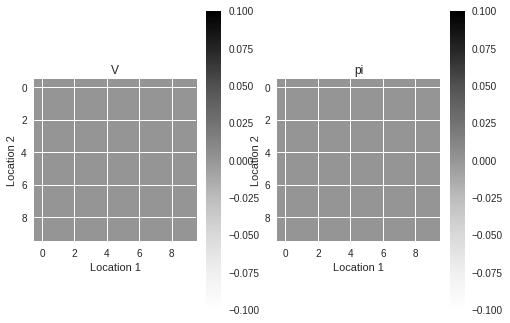

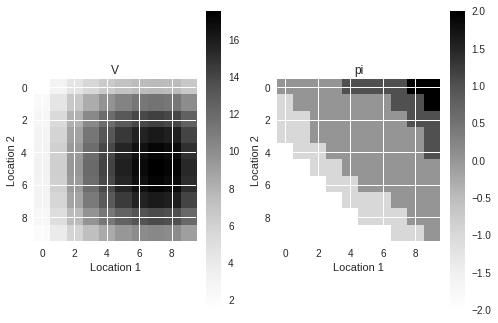

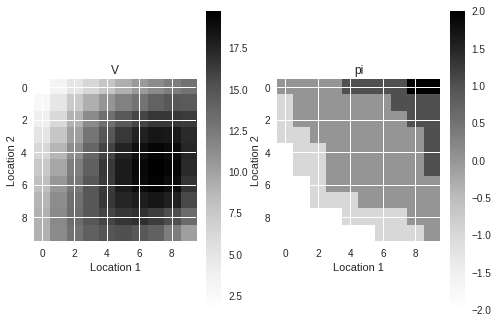

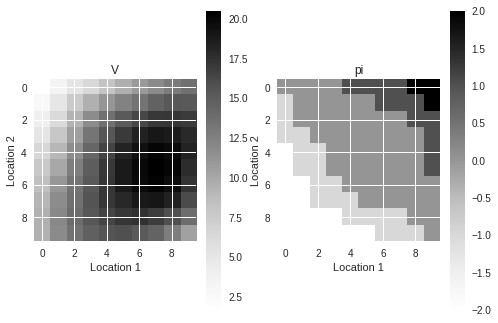

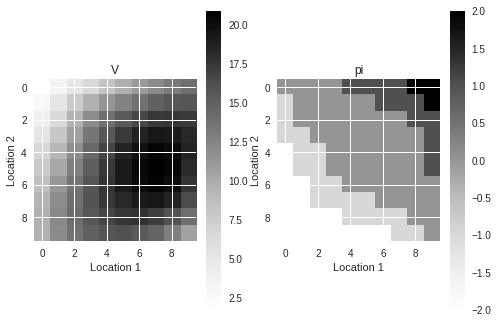

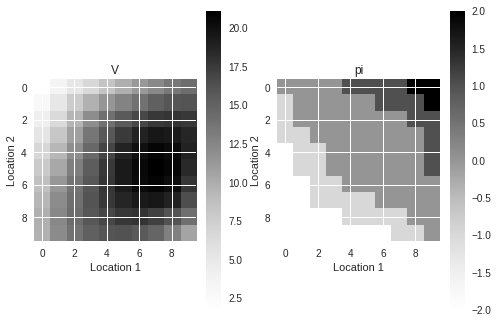

In [1]:
import os
import numpy as np
from scipy.stats.distributions import poisson
import matplotlib
import matplotlib.pyplot as plt

def policy_evaluation(V, pi, PR, gamma):
    """
    V should be a dict containing values for all states
    pi should be a dict containing the chosen action for each state
    P contains the transition probabilities P(s'|s,a)
    R contains the reward function R(s',s,a)
    gamma is the discount factor
    """

    global MAX_CARS, THETA

    Delta = np.inf

    while Delta > THETA:
        print 'entering while'
        Delta = 0
        
        for s1 in range(MAX_CARS):
            for s2 in range(MAX_CARS):
        
                print 'value evaluation for state %i,%i' % (s1, s2)
                v = V[s1,s2]
                a = pi[s1,s2]
                V[s1,s2] = 0
                for s1_prime in range(MAX_CARS):
                    for s2_prime in range(MAX_CARS):
                        # V[s] += P[s,a,s_prime]*(R[s,a,s_prime] + gamma*V[s_prime]) # dictionary version
                        P_sas_prime, R_sas_prime = PR((s1,s2), a, (s1_prime, s2_prime)) # funciton version
                        V[s1, s2] += P_sas_prime*(R_sas_prime + gamma*V[s1_prime, s2_prime]) # function version
                Delta = max(Delta, abs(v - V[s1, s2]))
                print Delta
        
    return V

def policy_improvement(V, pi, actions, PR, gamma):
    policy_stable = True


    for s1 in range(MAX_CARS):
        for s2 in range(MAX_CARS):
    
            print 'policy improvement for state %i/%i' % (s1, s2)
            old_action = pi[s1, s2]
    
            max_return = -np.inf
            argmax_a = -np.inf
    
            for a in actions:
                expected_return = 0
                for s1_prime in range(MAX_CARS):
                    for s2_prime in range(MAX_CARS):

                    
                        P_sas_prime, R_sas_prime = PR((s1,s2), a, (s1_prime, s2_prime)) # funciton version
                        expected_return += P_sas_prime*(R_sas_prime + gamma*V[s1_prime, s2_prime]) # function version
                    
                if expected_return > max_return:
                    max_return = expected_return
                    argmax_a = a
                
            pi[s1, s2] = argmax_a
            
            if old_action != pi[s1, s2]:
                policy_stable = False
        
    return pi, policy_stable
                
def PR(s, a, s_prime):
    global lambda_ret1, lambda_req1, lambda_ret2, lambda_req2, MAX_TRIPS

    if np.abs(a)>MAX_TRIPS:
        # maximum 5 cars returned
        return 0
    morning_loc1 = s[0] + a
    morning_loc2 = s[1] - a

    night_loc1 = s_prime[0]
    night_loc2 = s_prime[1]

    P1, R1 = prob_ret_req(morning_loc1, night_loc1, lambda_ret1, lambda_req1)
    P2, R2 = prob_ret_req(morning_loc2, night_loc2, lambda_ret2, lambda_req2)
    
    P = P1 * P2
    R = R1 + R2 - np.abs(a)*2

    return P, R

def prob_ret_req(n_morning, n_night, lambda_ret, lambda_req):
    """ 
    Probability for one agency of having n_morning cars in the morning and
    n_night cars in the night. Depends on the probabilities of returns and
    requests, as well as the max car availability.
    """
    prob = 0
    difference = n_night - n_morning
    R = 0

    for ret in range(int(10*lambda_ret)):
        for req in range(int(10*lambda_req)):
            if ret-req != difference:
                continue
            p_ret = poisson.pmf(ret, lambda_ret)
            p_req = poisson.pmf(req, lambda_req)
            


            prob += p_ret*p_req

            R += p_ret * p_req * req * 10  # expected reward

    return prob, R

def plot(V, pi, it):
    
    fig, axes = plt.subplots(1, 2)
    
    ax = axes[0]
    im = ax.imshow(V, interpolation='none')
    ax.set_title('V')
    ax.set_xlabel('Location 1')
    ax.set_ylabel('Location 2')
    
    plt.colorbar(im, ax=ax)

    ax = axes[1]
    im = ax.imshow(pi, interpolation='none')
    ax.set_title('pi')
    ax.set_xlabel('Location 1')
    ax.set_ylabel('Location 2')
    
    plt.colorbar(im, ax=ax)
    plt.savefig('figures/result_iter_%02i.png' % it)

acc_factor = 2.0

THETA = 5.0
MAX_CARS = int(20 / acc_factor)
MAX_TRIPS = int(5 / acc_factor)

# DEFINE PARAMETERS

actions = range(-1*MAX_TRIPS, MAX_TRIPS+1)

V = np.zeros((MAX_CARS, MAX_CARS))
pi = np.zeros((MAX_CARS, MAX_CARS))


gamma = 0.9

lambda_ret1 = 3/acc_factor
lambda_ret2 = 2/acc_factor
lambda_req1 = 3/acc_factor
lambda_req2 = 4/acc_factor


# RUN ITERATIONS
policy_stable = False

it = 0

plot(V, pi, it)

while not policy_stable:
    V = policy_evaluation(V, pi, PR, gamma)
    pi, policy_stable = policy_improvement(V, pi, actions, PR, gamma)
    it += 1
    plot(V, pi, it)

In [0]:

import os
import numpy as np
from scipy.stats.distributions import poisson
import matplotlib
import matplotlib.pyplot as plt

def value_iteration(V, pi, PR, gamma):
    global THETA

    Delta = np.inf

    it = 0

    while Delta > THETA:
        Delta = 0
        for s in range(100):
            v = V[s]

            argmax_a = -np.inf
            max_return = -np.inf
            for a in range(min(s,100-s)+1):
                expected_return = 0
                for s_prime in [s-a, s+a]:
                    P, R = PR(s,a,s_prime)
                    expected_return += P * (R + gamma * V[s_prime])

                    
                if expected_return> max_return:
                    max_return = expected_return
                    argmax_a = a

            V[s] = max_return
            pi[s] = argmax_a
            Delta = max(Delta, np.abs(v-V[s]))
        
        it += 1            
    return V, pi

def PR(s, a, s_prime):
    global p_h


    # with probabilty p_h you get s+a, with probability 1-p_h you get s-a
    if s_prime == s+a:
        return p_h, int(s_prime==100)
    elif s_prime == s-a:
        return 1-p_h, 0

    else:
        return 0, 0


def plot(V, pi):
    global fig, axes    
    fig, axes = plt.subplots(1, 2)

    ax = axes[0]
    im = ax.plot(V)
    ax.set_title('V')
    
    ax = axes[1]
    im = ax.bar(range(101),pi)
    ax.set_title('pi')
    
    plt.clf()

THETA = 1e-16
p_h = 0.4

gamma = 1;

V = np.zeros(101)
pi = np.zeros(101)


V, pi = value_iteration(V, pi, PR, gamma)